# 2. Sprite Visualization & Processing
We create cluster labels for our embedded chunks/tokens $\mathbf{z}$, which in turn provides easy visualization of the full sequences. We call these false-color representations "sprites". We perform the clustering procedure over a random sample of $\mathbf{z}$'s gathered from the training set. 

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
modelstr = "tile2vec" # "tile2vec", "vit_iid","clip","plip"

In [19]:
if modelstr == "tile2vec":
    embed_dict_path = "/home/lofi/lofi/src/outputs_tile2vec/train_sampled_inference_z_embeds.obj"
elif modelstr == "vit_iid":
    embed_dict_path = "/home/lofi/lofi/src/outputs_vit/train_vit_iid_sampled_inference_z_embeds.obj"
elif modelstr == "clip": 
    embed_dict_path = "/home/lofi/lofi/src/outputs_clip/train_clip_sampled_inference_z_embeds.obj"
elif modelstr == "plip":
    embed_dict_path = "/home/lofi/lofi/src/outputs_plip/train_plip_sampled_inference_z_embeds.obj"

# 2A. Clustering & Quantization

In [22]:
from embed_patches import *
if modelstr == "vit_iid":
    sse, sil = calculate_ideal_k(embed_dict_path, ks=list(range(2,21)), mode="memmap")
else:
    sse, sil = calculate_ideal_k(embed_dict_path, ks=list(range(2,21)))

/home/envs/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/envs/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/envs/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/envs/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/envs/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

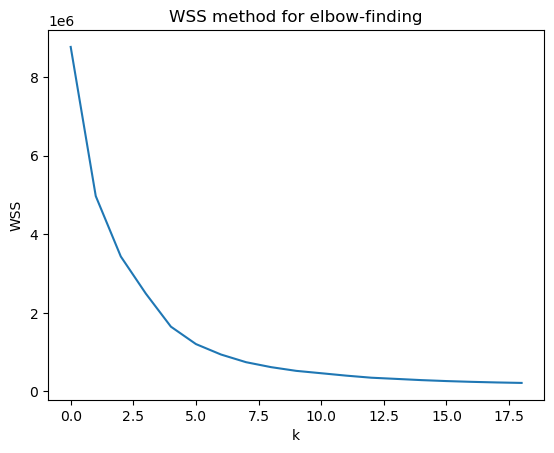

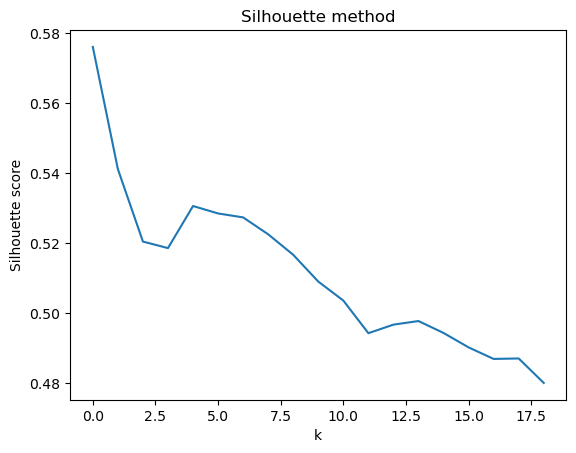

In [23]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(sse)
plt.title("WSS method for elbow-finding")
plt.xlabel("k")
plt.ylabel("WSS")
plt.show()

plt.figure()
plt.plot(sil)
plt.title("Silhouette method")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.show()

Using the "elbow method", a good choice of $K$ from these metrics looks to be $K=4,5,6,7,8$. Play around with these choices below.

sampled 8 salient objects!
total embeds: 4440
collapsing from dim 128 --> 2


/home/envs/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/envs/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/envs/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


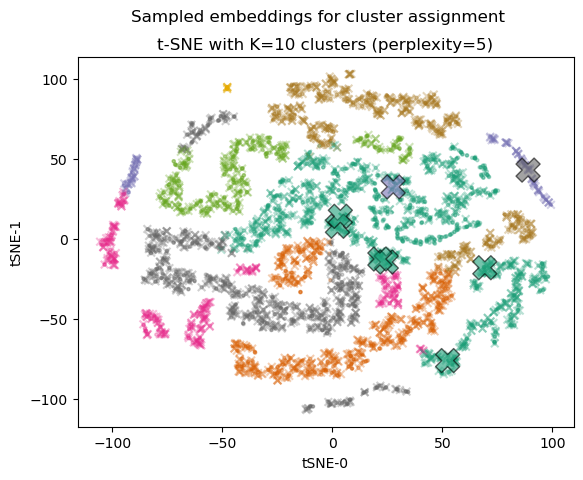

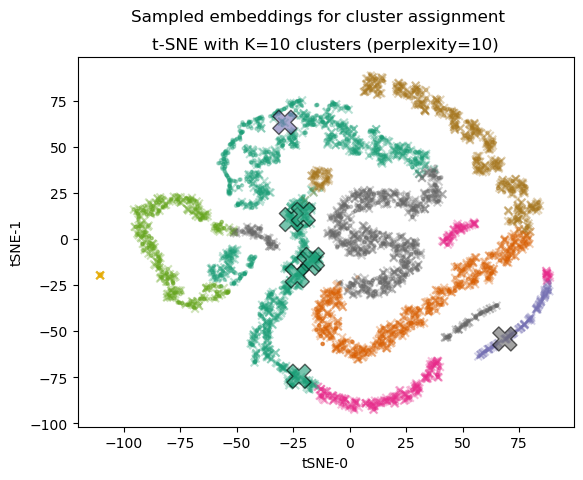

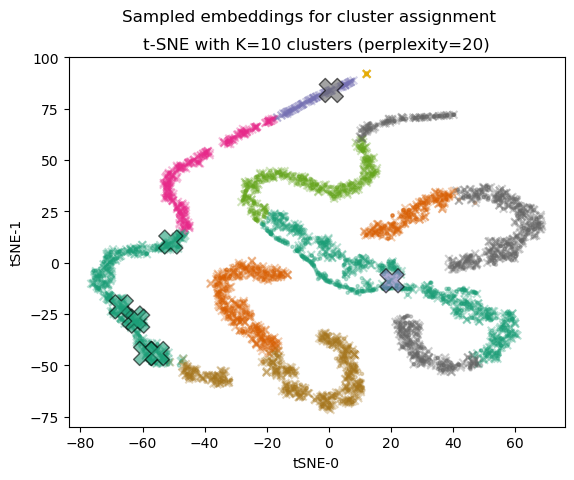

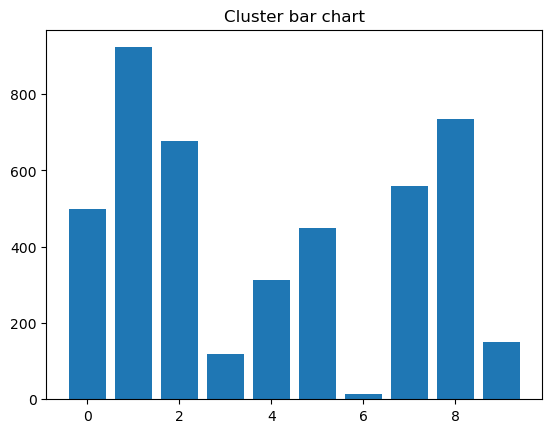

In [24]:
if modelstr == "vit_iid":
    kmeans_model = fit_clustering(embed_dict_path, K=10, mode="memmap", mapping_path="/home/lofi/lofi/src/outputs_vit/train_vit_iid_chunkid_position.obj")
else:    
    kmeans_model = fit_clustering(embed_dict_path, K=10)

We can also take a look at the embedding lengths of the training set to get a sense of how the embedding space is constructed (e.g. manifold, hypersphere, etc.)

4440 512


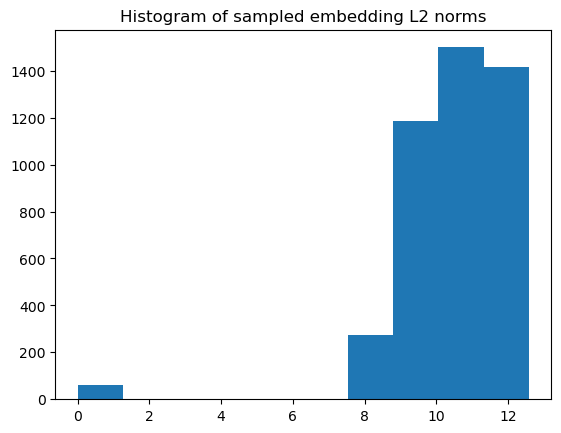

In [9]:
if modelstr == "vit_iid":
    get_magnitudes(embed_dict_path, mode="memmap")
else:
    get_magnitudes(embed_dict_path)

# 2B. Sprite Construction for Train Set
We can take a look at the diversity of the training set by playing with our embedded sequences $\mathbf{Z}$. Below, we show sprites for tumor and normal samples.

In [10]:
if modelstr == "tile2vec":
    Z_pathdir = "/home/data/tinycam/train/Zs"
elif modelstr == "vit_iid":
    Z_pathdir = "/home/data/tinycam/train/Zs_vit"
elif modelstr == "clip":
    Z_pathdir = "/home/data/tinycam/train/Zs_clip"
elif modelstr == "plip":
    Z_pathdir = "/home/data/tinycam/train/Zs_plip"

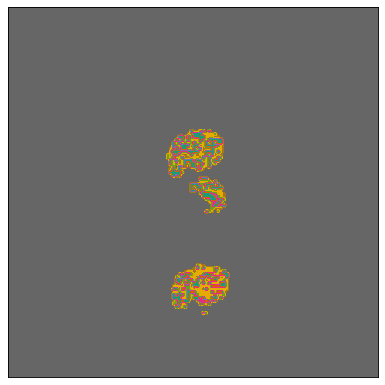

In [11]:
Z_id = "Z-tumor_045.npy"
Z_path = Z_pathdir + "/" + Z_id
if modelstr == "vit_iid":
    visualize_Z(Z_path, kmeans_model, mode="memmap")
else:
    visualize_Z(Z_path, kmeans_model)

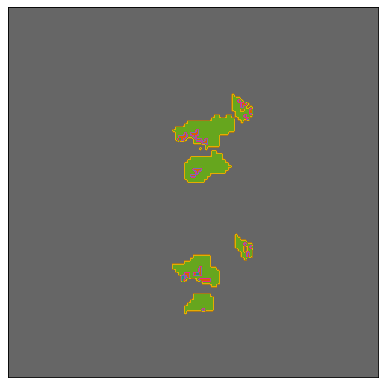

In [12]:
Z_id = "Z-normal_045.npy"
Z_path = Z_pathdir + "/" + Z_id
if modelstr == "vit_iid":
    visualize_Z(Z_path, kmeans_model, mode="memmap")
else:
    visualize_Z(Z_path, kmeans_model)

# 2C. Cleaning up the Test Set
Test set $\mathbf{Z}$'s likely have slide background patches that need removal. The training set was constructed with border trimmming since we wanted wanted to be careful of what our trained models saw — border trimming thus ensured solely tissue tokens/patches. On the test-set this stringent trimming was not implemented since we noticed tissue quite close to borders and we didn't want to lose it due to lenient filtration. There, we remove borders in post-processing with a full view of the embedding map, $\mathbf{Z}$. Below you see a binarized and flattened view (wrt to channel space of $\mathbf{Z}$). You'll notice that the first set of thumbnails contain white vert/horiz lines — these are the borders to wipe clean!

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from embed_patches import clean_Zs

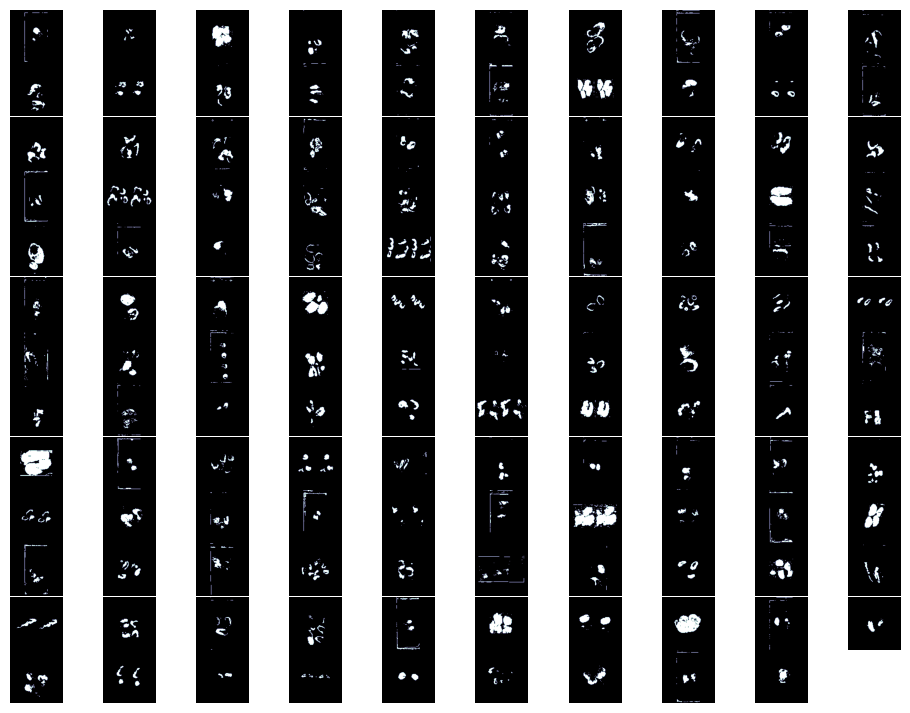

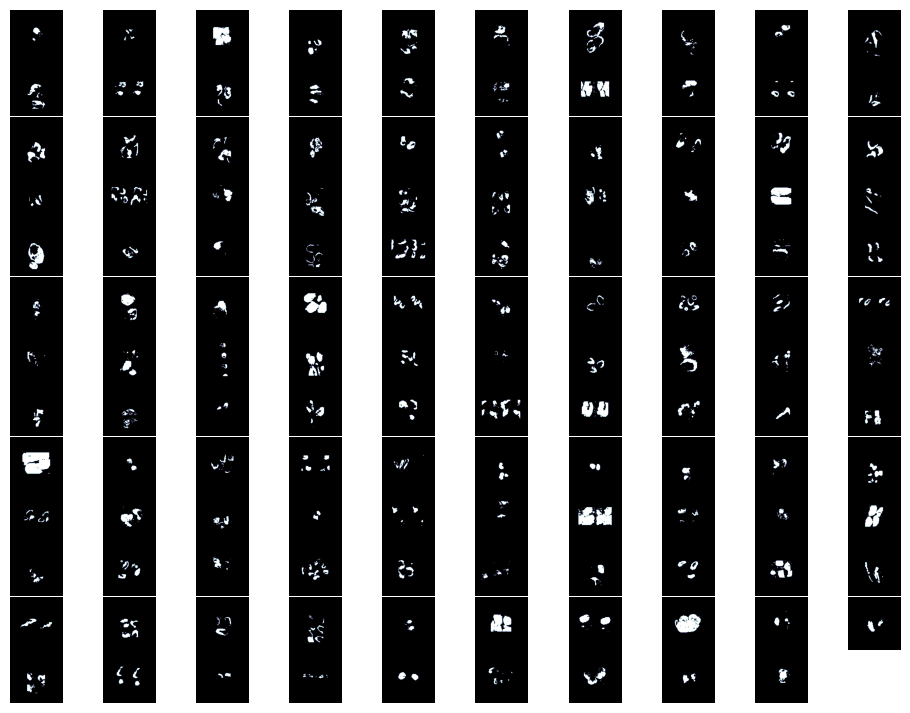

In [14]:
if modelstr == "tile2vec":
    Z_test_path = "/home/data/tinycam/test/Zs"
    save_dir = "/home/data/tinycam/test/clean_Zs"
elif modelstr == "vit_iid":
    Z_test_path = "/home/data/tinycam/test/Zs_vit"
    save_dir = "/home/data/tinycam/test/clean_Zs_vit"
elif modelstr == "clip":
    Z_test_path = "/home/data/tinycam/test/Zs_clip"
    save_dir = "/home/data/tinycam/test/clean_Zs_clip"
elif modelstr == "plip":
    Z_test_path = "/home/data/tinycam/test/Zs_plip"
    save_dir = "/home/data/tinycam/test/clean_Zs_plip"

clean_Zs(Z_test_path, save_dir)

Check out some of the Zs to get a sense of cleanliness...

In [15]:
if modelstr == "tile2vec":
    Z_pathdir = "/home/data/tinycam/test/clean_Zs"
elif modelstr == "vit_iid":
    Z_pathdir = "/home/data/tinycam/test/clean_Zs_vit"
elif modelstr == "clip":
    Z_pathdir = "/home/data/tinycam/test/clean_Zs_clip"
elif modelstr == "plip":
    Z_pathdir = "/home/data/tinycam/test/clean_Zs_plip"

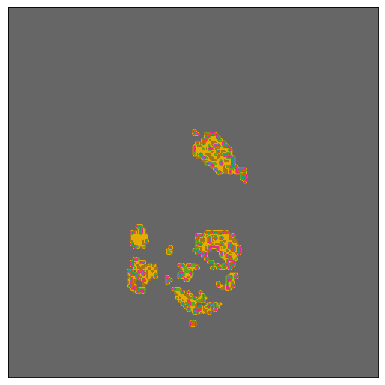

In [16]:
Z_id = "Z-test_006.npy"
Z_path = Z_pathdir + "/" + Z_id
if modelstr == "vit_iid":
    visualize_Z(Z_path, kmeans_model, mode="memmap")
else:
    visualize_Z(Z_path, kmeans_model)

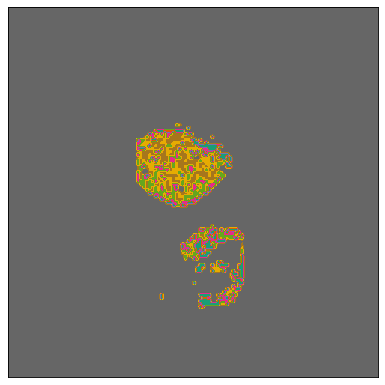

In [17]:
Z_id = "Z-test_010.npy"
Z_path = Z_pathdir + "/" + Z_id
if modelstr == "vit_iid":
    visualize_Z(Z_path, kmeans_model, mode="memmap")
else:
    visualize_Z(Z_path, kmeans_model)

# 3. Exploring the scale of Salient Objects
We first need a complete view of the data. Let's first generate test set salient object masks (from provided XML files) at patch scale + load dictionary of test-set dimensions. Then we create:
- histogram of % salient objects
- historgram of image pixel space of original gigpixel dataset (H,W)
- histogram of % valid/foreground tokens per sequence

First we generate ground truth masks from XML files

In [18]:
gt_path = "/home/data/tinycam/test/cam16-eval/csnaftp_gdrive-16/lesion_annotations"
gt_save_path = "/home/data/tinycam/test/gt_masks"
#-------rerun if needed: can take 30min-----------
# level, resolution = 5, None
# print("we have", len(os.listdir(gt_path)), "masks to generate!")
# for i, mask in enumerate(os.listdir(gt_path)):
#     id = mask.split(".xml")[0]
#     print("started processing mask", i, "| ID:", id)
#     og_dims = (test_dims[id + ".tif"][0][1], test_dims[id + ".tif"][0][0]) # swap dims
#     # og_dims = test_dims[id + ".tif"][0]
#     mask_np = computeEvaluationMaskXML_lowres(gt_path + "/" + mask, og_dims, resolution, level)
#     if mask_np is None:
#         break
#     np.save(gt_save_path + "/" + id + "_gt", mask_np)
#     print("finished processing mask", i, "| ID:", id)


You can view dimensions if desired

In [19]:
sods = []
sums = []
mask_names = []
for mask_name in os.listdir(gt_save_path):
    mask = np.load(gt_save_path + "/" + mask_name)
    mask_names.append(mask_name)
    summed = np.sum(mask)
    sums.append(summed)
    sods.append(summed / mask.size)

sodcount_dict = dict(zip(mask_names, sums))

In [20]:
from utils import deserialize
custom_test_dict_path = "/home/data/tinycam/test/cam16-eval/my_data/cam16_test_dim_dict.obj"
test_dims = deserialize(custom_test_dict_path)

In [21]:
label_dict_path_test = "/home/lofi/lofi/src/outputs/test-cam-cam16-224-background-labeldict.obj"
test_label_dict = utils.deserialize(label_dict_path_test)

In [22]:
Hs, Ws = [], []
for key in test_dims.keys():
    og_dims = test_dims[key][0]
    W, H = og_dims[0], og_dims[1]
    Hs.append(H)
    Ws.append(W)

In [23]:
percent_patches_0, percent_patches_1 = [], []
Z_path = "/home/data/tinycam/test/clean_Zs"
for key in test_dims.keys():
    patch_dims = test_dims[key][3]
    total = patch_dims[0] * patch_dims[1]
    
    im_id = key.split(".tif")[0]
    Z = np.load(Z_path + "/" + "Z-"+im_id+".npy")
    flatZ = np.sum(Z, axis=2) > 0
    valid = np.sum(flatZ)
    lab = test_label_dict[im_id]
    if lab == 0:
        percent_patches_0.append(valid/total)
    else:
        percent_patches_1.append(valid/total)

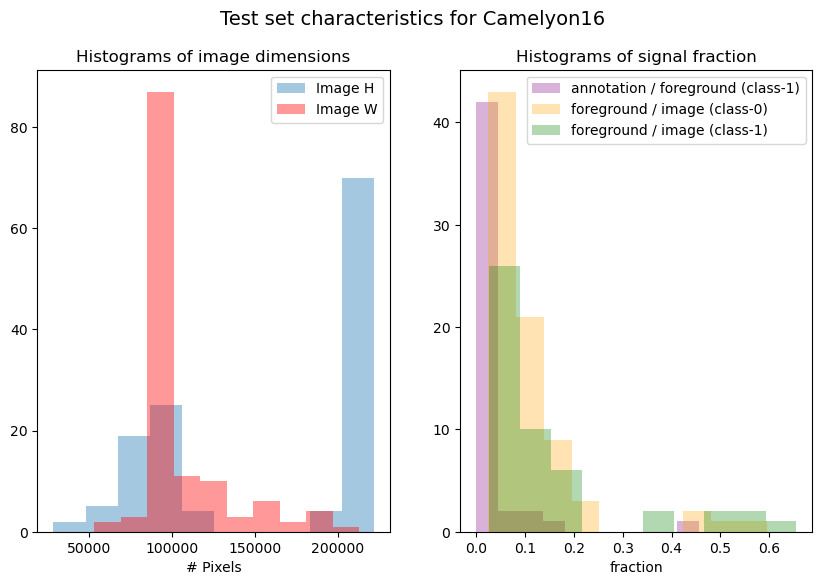

In [24]:
import seaborn as sns

plt.figure(figsize=(10,6))
plt.suptitle("Test set characteristics for Camelyon16", fontsize=14)
plt.subplot(1,2,1)
plt.title("Histograms of image dimensions", fontsize=12)
plt.hist(Hs, alpha=0.4, bins=10, label='Image H')
plt.hist(Ws, alpha=0.4, bins=10, label='Image W', color="red")
plt.xlabel("# Pixels")
plt.legend()
plt.subplot(1,2,2)
plt.title("Histograms of signal fraction", fontsize=12)
plt.hist(sods, alpha=0.3, bins=10, color="purple", label='annotation / foreground (class-1)')
plt.hist(percent_patches_0, alpha=0.3, bins=10, color="orange", label='foreground / image (class-0)')
plt.hist(percent_patches_1, alpha=0.3, bins=10, color="green", label='foreground / image (class-1)')
plt.xlabel("fraction")
plt.legend()
plt.show()